# Peak levels

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Peak_Levels import Peak_Levels
from util.Save_result_return import save_to_csv




## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Peak_Levels

In [6]:
account_size = 20000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/2000, )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   83.541543
Equity Final [$]                  18754.59085
Equity Peak [$]                   20027.46555
Return [%]                          -6.227046
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.320762
Volatility (Ann.) [%]                0.491335
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                     -6.5195
Avg. Drawdown [%]                   -1.696356
Max. Drawdown Duration     5413 days 00:00:00
Avg. Drawdown Duration     1364 days 00:00:00
# Trades                                 3567
Win Rate [%]                        17.409588
Best Trade [%]                       2.707783
Worst Trade [%]                     -2.664988
Avg. Trade [%]                    

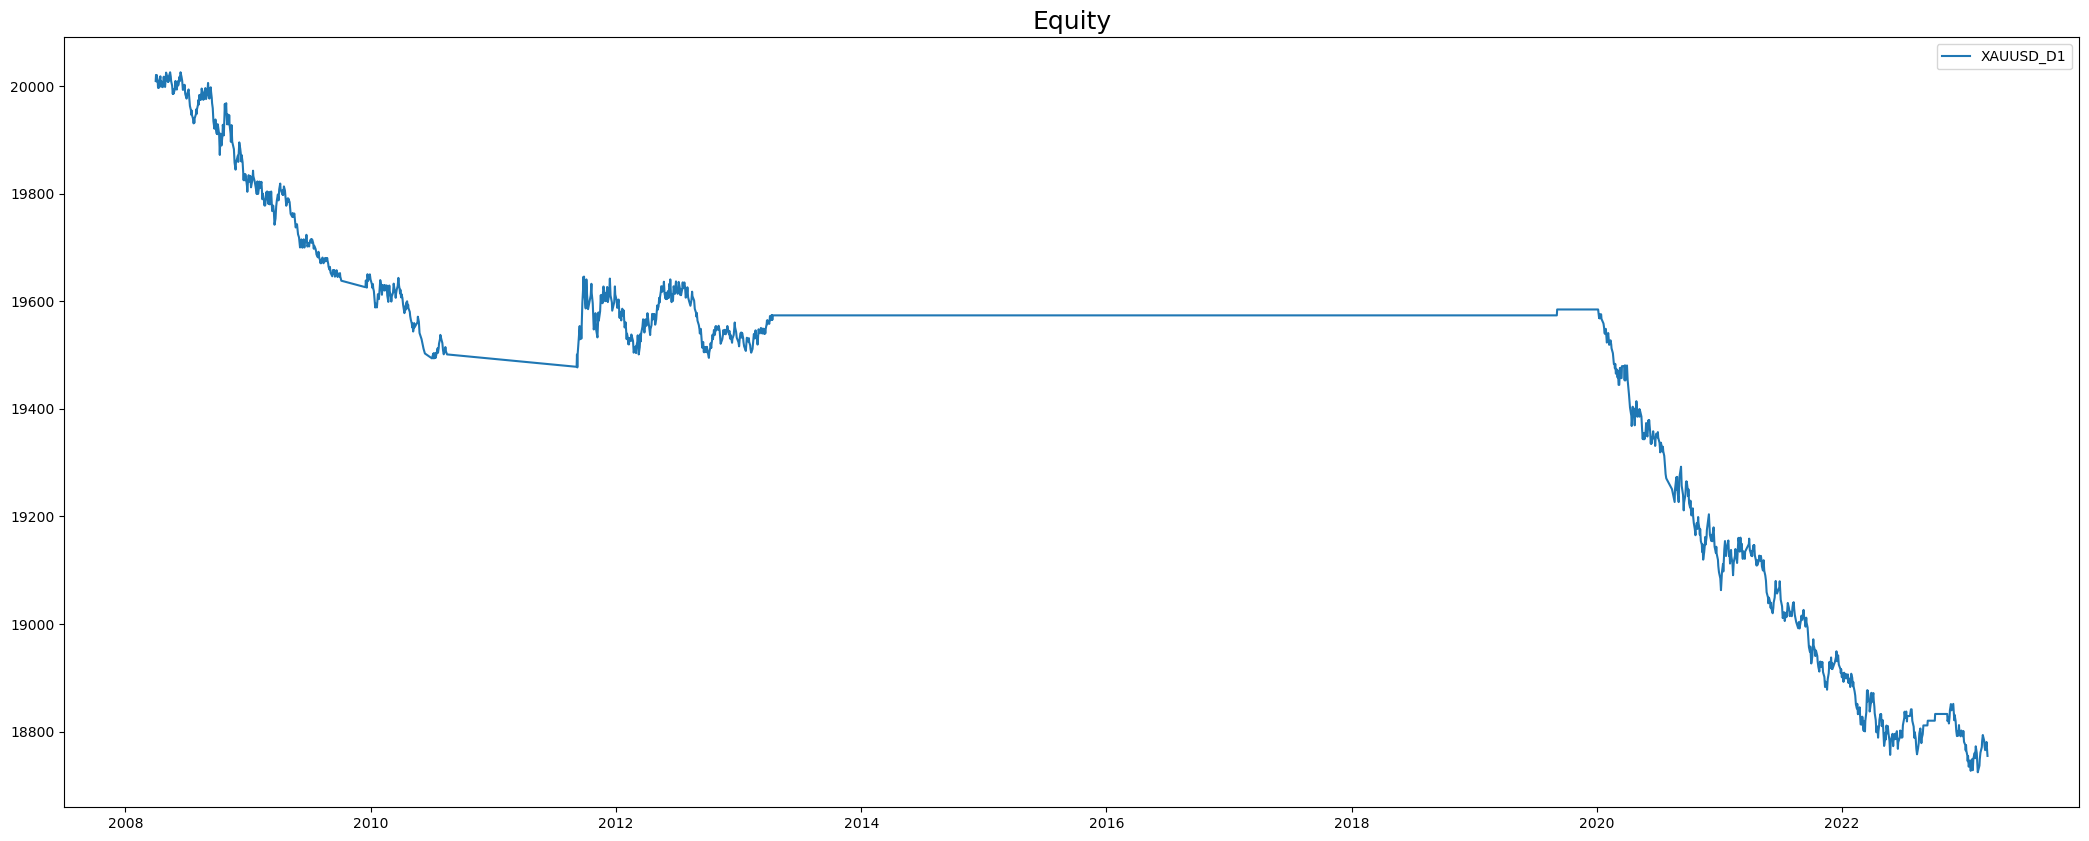

In [8]:
plot_equity_trades(result_D1['_trades'],'XAUUSD_D1' , account_size)

### Save output

In [9]:
# save_to_csv(result_D1, '../../out/Technical_Strategy/Peak_Levels/Backtest/result_D1.csv')  

## TF H4

In [10]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/2000, )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   99.907607
Equity Final [$]                  19504.02305
Equity Peak [$]                  20000.205875
Return [%]                          -2.479885
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.125404
Volatility (Ann.) [%]                0.301446
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.431013
Avg. Drawdown [%]                   -1.725777
Max. Drawdown Duration     5908 days 08:00:00
Avg. Drawdown Duration     2954 days 16:00:00
# Trades                                24780
Win Rate [%]                         4.067797
Best Trade [%]                       0.844153
Worst Trade [%]                     -1.590012
Avg. Trade [%]                    

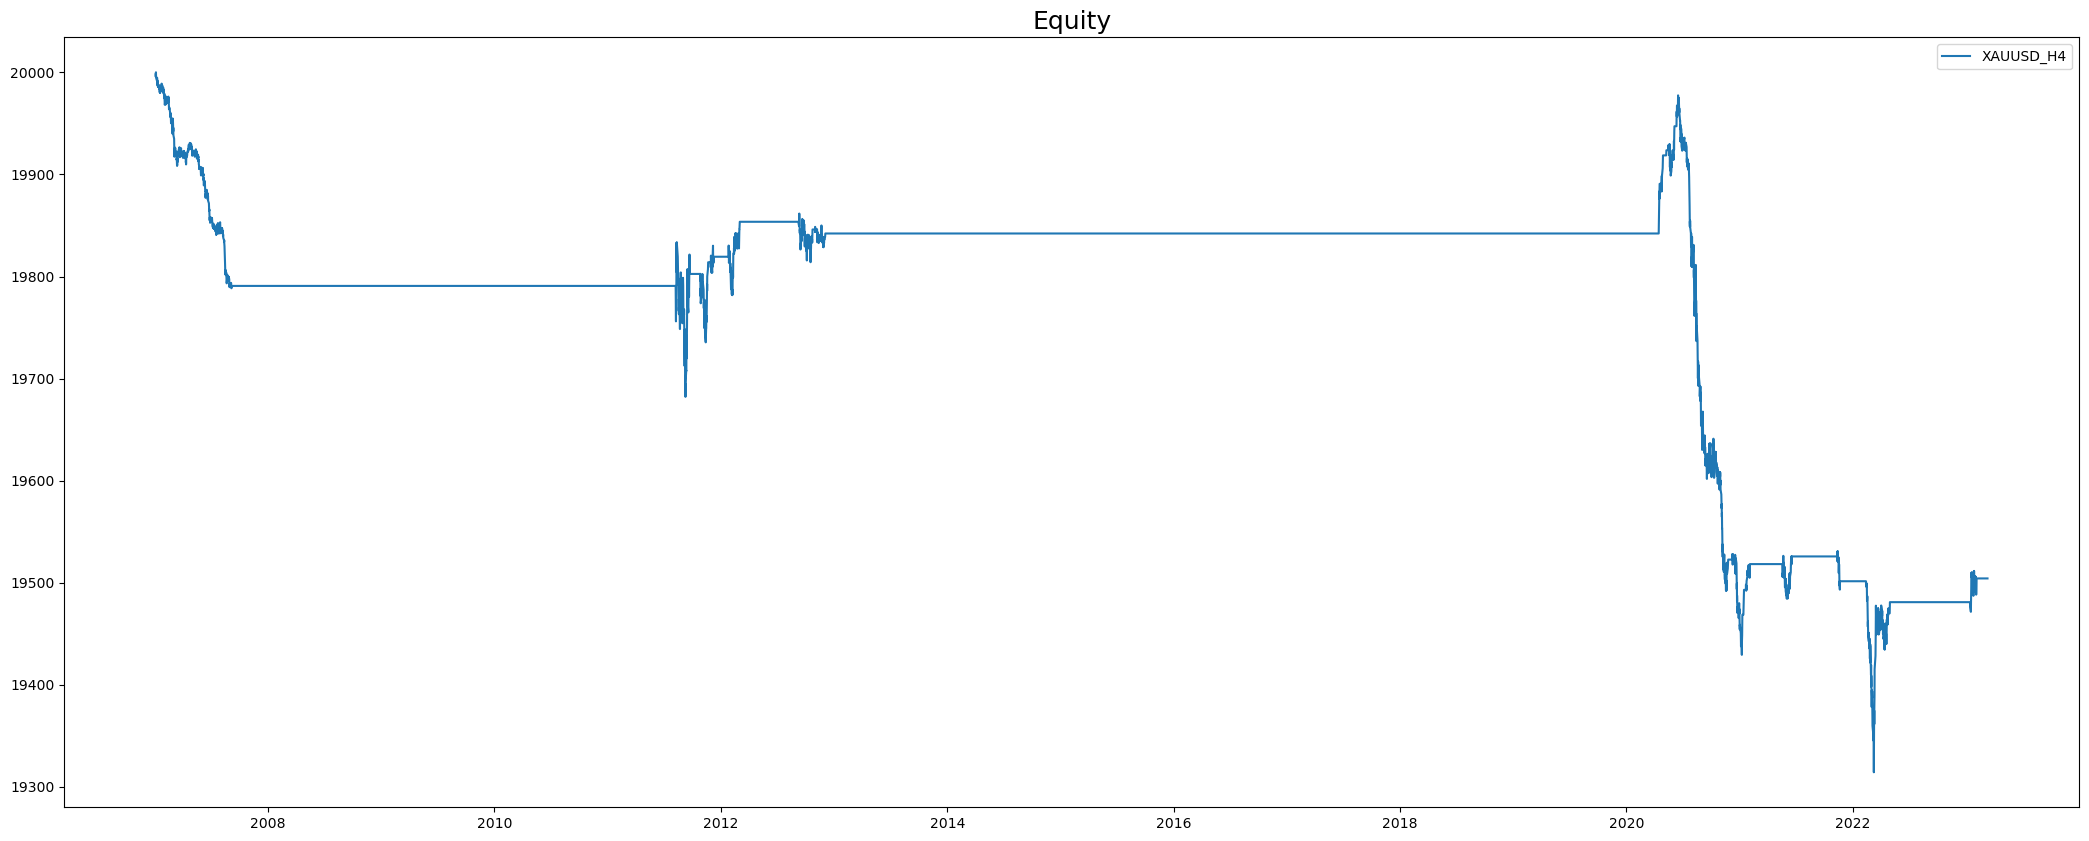

In [11]:
plot_equity_trades(result_H4['_trades'], 'XAUUSD_H4' , account_size)

### Save output

In [16]:
# save_to_csv(result_H4, '../../out/Technical_Strategy/Peak_Levels//Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/2000, )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   99.975499
Equity Final [$]                    19650.331
Equity Peak [$]                       20000.0
Return [%]                          -1.748345
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -0.087966
Volatility (Ann.) [%]                0.173603
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.970241
Avg. Drawdown [%]                   -1.970241
Max. Drawdown Duration     5911 days 21:00:00
Avg. Drawdown Duration     5911 days 21:00:00
# Trades                                97002
Win Rate [%]                         0.915445
Best Trade [%]                       0.527434
Worst Trade [%]                      -0.55571
Avg. Trade [%]                    

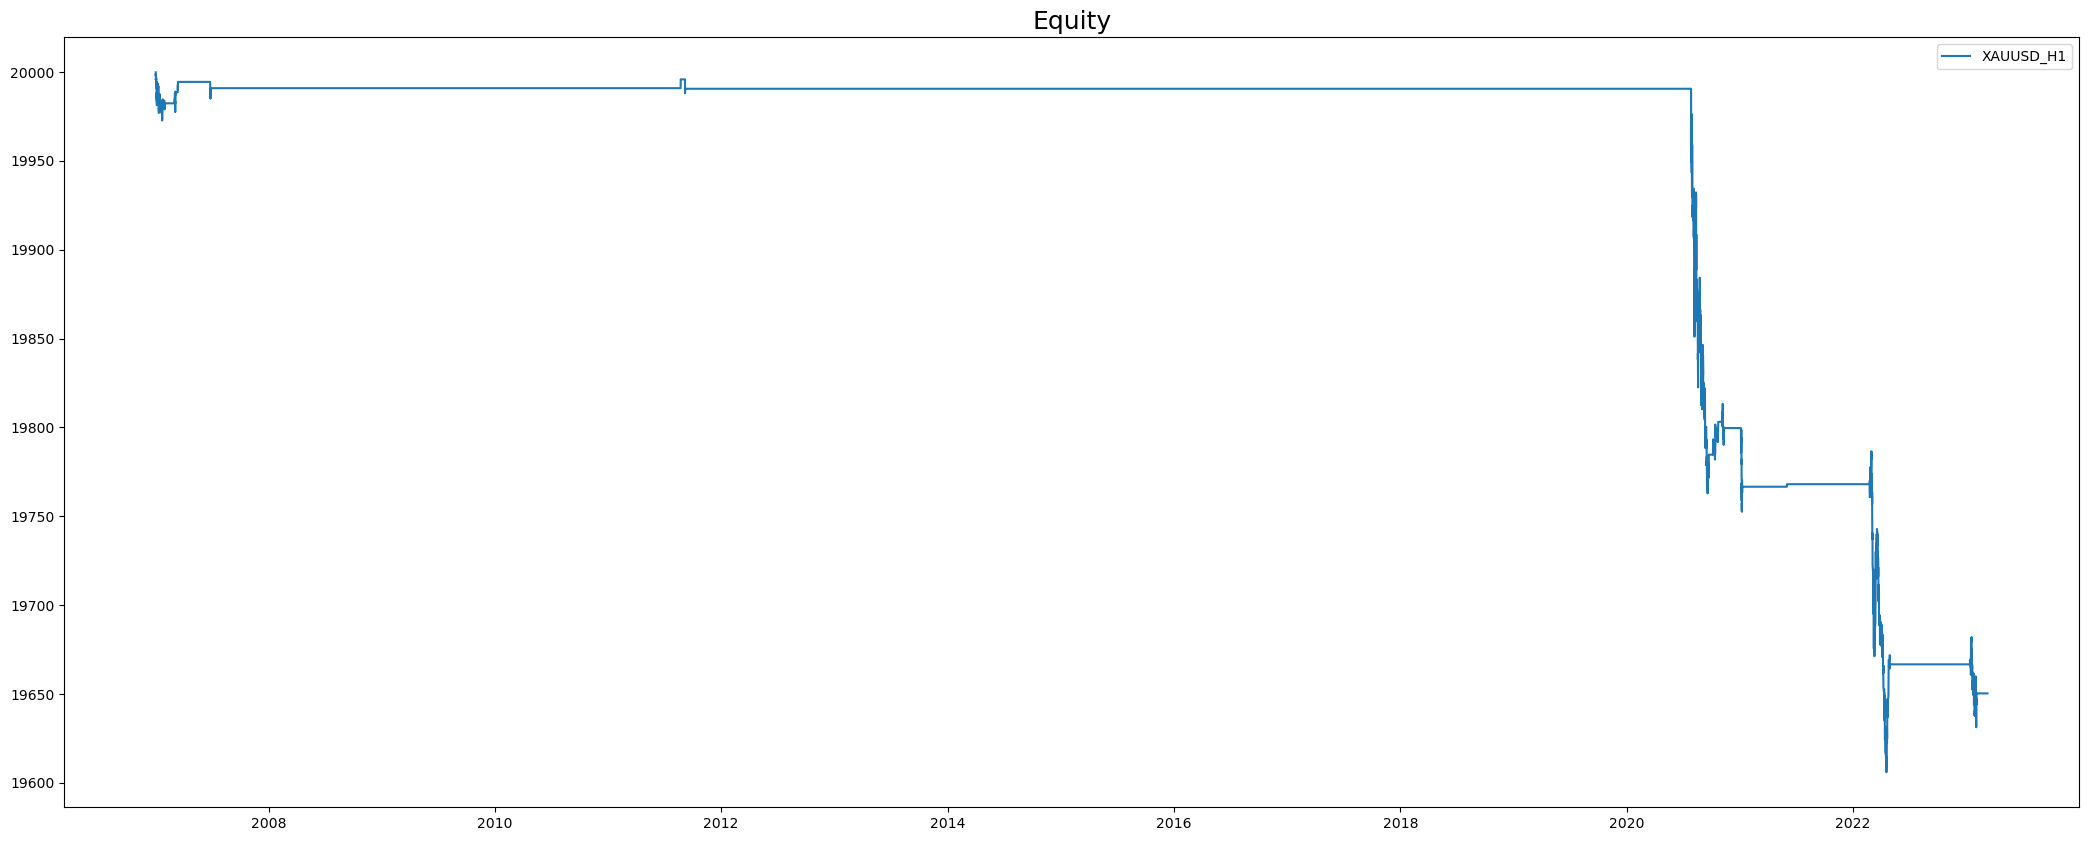

In [14]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

### Save output

In [17]:
# save_to_csv(result_H1, '../../out/Technical_Strategy/Peak_Levels//Backtest/result_H1.csv')  

## TF M30 

In [18]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/2000, )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   99.988732
Equity Final [$]                 19273.083275
Equity Peak [$]                       20000.0
Return [%]                          -3.634584
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                   -0.184072
Volatility (Ann.) [%]                0.192113
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.708644
Avg. Drawdown [%]                   -3.708644
Max. Drawdown Duration     5912 days 07:30:00
Avg. Drawdown Duration     5912 days 07:30:00
# Trades                               193703
Win Rate [%]                         0.810519
Best Trade [%]                       0.396775
Worst Trade [%]                     -0.410629
Avg. Trade [%]                    

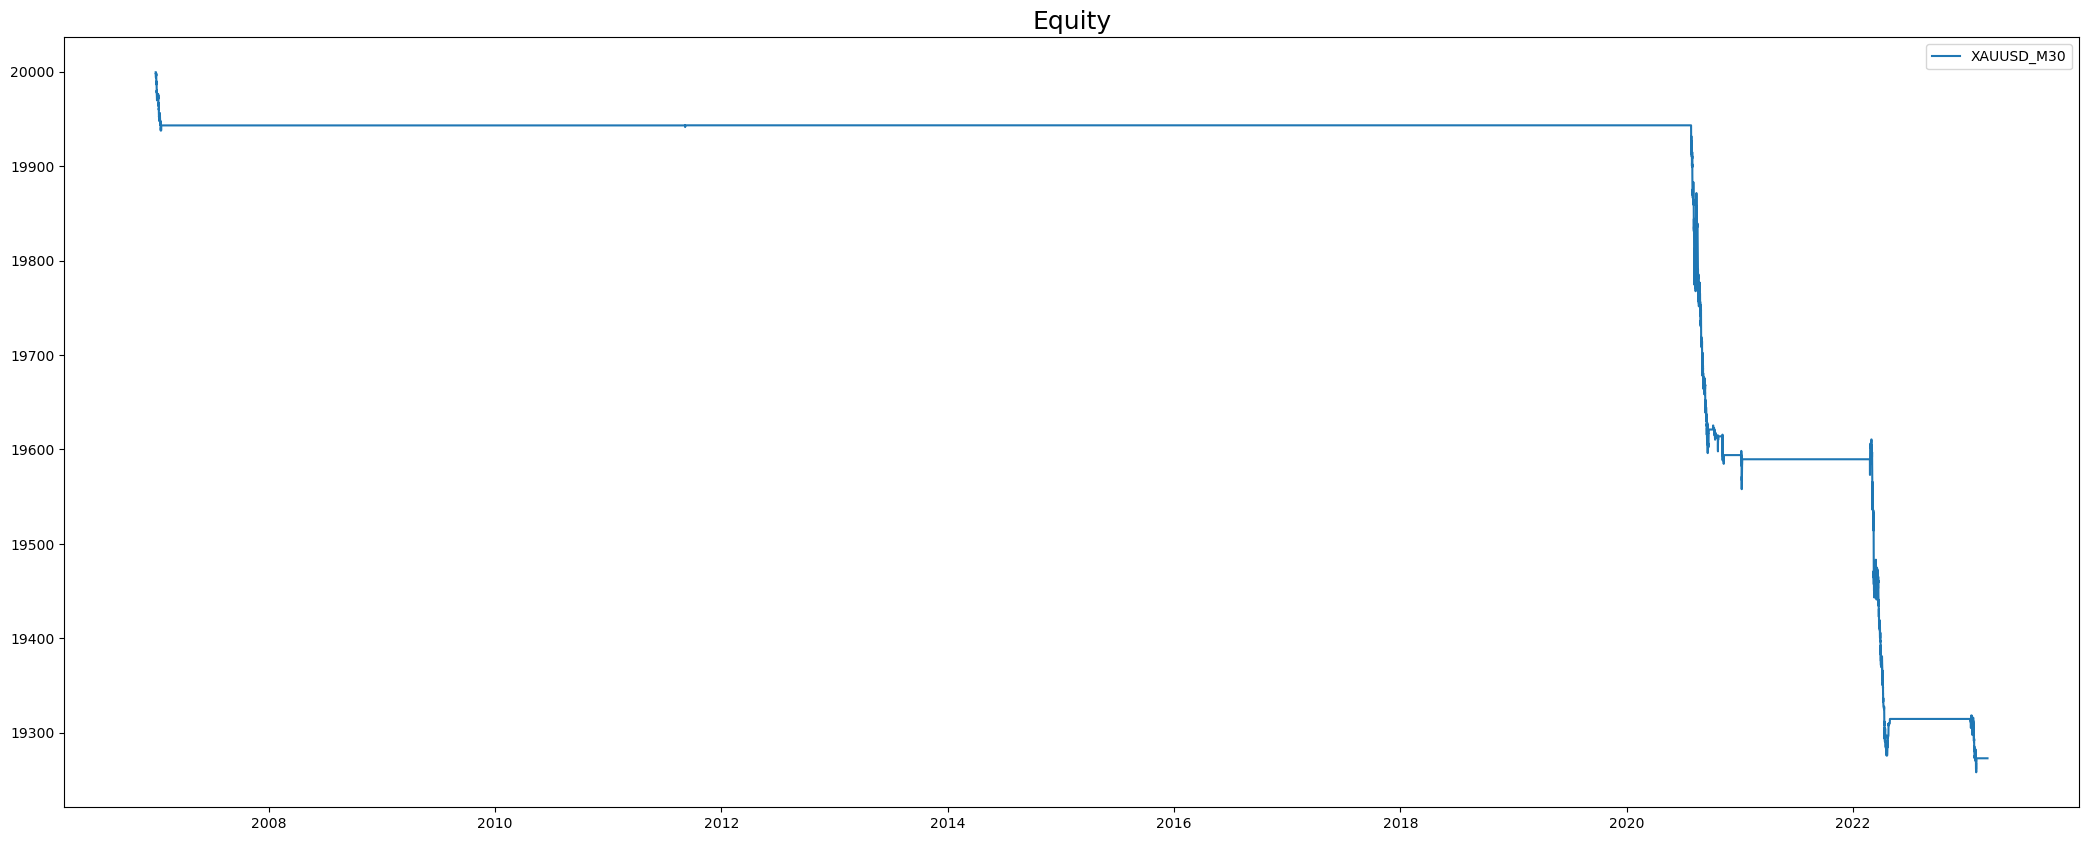

In [19]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)

### Save output

In [20]:
# save_to_csv(result_M30, '../../out/Technical_Strategy/Peak_Levels//Backtest/result_M30.csv')  